In [8]:
from typing import cast
import tensorflow as tf
import keras
import retina
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv(retina.filesys.DATA_CSV_PATH, index_col=False)
labels = df["label"]
df = df.drop(columns=["label"])
df

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x63,y63,x64,y64,x65,y65,x66,y66,x67,y67
0,0.079149,0.415385,0.085124,0.524534,0.097658,0.633034,0.115489,0.741669,0.158085,0.839812,...,0.540644,0.799620,0.618910,0.813626,0.540251,0.824765,0.494556,0.830039,0.448553,0.825274
1,0.166672,0.314662,0.157875,0.424246,0.158399,0.530433,0.173777,0.641301,0.205706,0.745427,...,0.552429,0.799298,0.652934,0.796978,0.552627,0.814192,0.504648,0.816424,0.457908,0.804896
2,0.078716,0.373026,0.066693,0.479249,0.062205,0.588160,0.075930,0.696685,0.111917,0.803102,...,0.524635,0.762741,0.605352,0.795998,0.521923,0.808392,0.476009,0.807918,0.429142,0.799172
3,0.092755,0.333213,0.104432,0.458606,0.125570,0.578626,0.157111,0.694572,0.206962,0.799460,...,0.575336,0.803657,0.680681,0.784185,0.572998,0.825852,0.525814,0.834946,0.479509,0.829201
4,0.168128,0.446216,0.165949,0.561713,0.179358,0.674292,0.208420,0.783846,0.247251,0.888572,...,0.558838,0.898252,0.713880,0.890286,0.558828,0.915155,0.504010,0.922708,0.456427,0.914323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,0.141367,0.430813,0.136084,0.535710,0.141258,0.641961,0.159933,0.747952,0.198797,0.847142,...,0.553287,0.778935,0.665226,0.785045,0.554056,0.856143,0.503291,0.862956,0.453465,0.852714
409,0.095889,0.477608,0.105937,0.584820,0.126490,0.692359,0.162128,0.798894,0.216012,0.893241,...,0.571322,0.786133,0.653021,0.798523,0.577609,0.849605,0.537169,0.859258,0.492155,0.856411
410,0.120411,0.413087,0.121941,0.522499,0.135949,0.630865,0.160593,0.740850,0.206053,0.844825,...,0.557833,0.818786,0.662868,0.813309,0.559499,0.859118,0.512707,0.866060,0.464994,0.859684
411,0.098509,0.393257,0.083284,0.506083,0.083999,0.621184,0.104489,0.734498,0.146503,0.841712,...,0.531007,0.817154,0.662701,0.813006,0.526689,0.901623,0.469208,0.908038,0.412386,0.895004


In [21]:
dataset = tf.data.Dataset.from_tensor_slices((df, labels))
train_dataset, test_dataset = keras.utils.split_dataset(dataset, shuffle=True, seed=42, left_size=0.7)
train_dataset, validation_dataset = keras.utils.split_dataset(train_dataset, shuffle=True, seed=42, left_size=0.7)

train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)
validation_dataset = validation_dataset.batch(64)

dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(136,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [39]:
model = keras.Sequential([
  keras.layers.Input(shape=(136,)),
  keras.layers.Dense(128, activation="relu"),
  keras.layers.Dense(6),
  keras.layers.Softmax(),
])

model.compile(
  optimizer=keras.optimizers.Adam(), # type: ignore
  loss=keras.losses.SparseCategoricalCrossentropy(),
  metrics=["accuracy"],
)

In [40]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.1838 - loss: 1.7976 - val_accuracy: 0.1954 - val_loss: 1.8772
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2684 - loss: 1.7415 - val_accuracy: 0.1954 - val_loss: 1.9140
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2684 - loss: 1.7388 - val_accuracy: 0.1954 - val_loss: 1.8711
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2684 - loss: 1.7327 - val_accuracy: 0.1954 - val_loss: 1.8598
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2684 - loss: 1.7311 - val_accuracy: 0.1954 - val_loss: 1.8731
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2684 - loss: 1.7310 - val_accuracy: 0.1954 - val_loss: 1.8796
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2684 - loss: 1.7307 - val_accuracy: 0.1954 - val_loss: 1.8717
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2684 - loss: 1.7292 - val_accuracy: 0.1954 - val_loss: 1.8672
Epoch 9

In [37]:
model.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2498 - loss: 1.7847


[1.8023817539215088, 0.24193547666072845]

C:\Users\Davin Tristan\AppData\Local\Temp\ipykernel_11280\469801421.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  accuracy_fig.show()


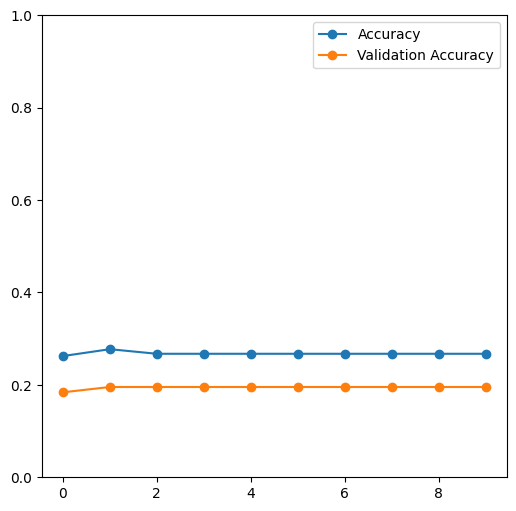

In [38]:
accuracy_fig = plt.figure(figsize=(6,6))
ax = accuracy_fig.add_subplot()
ax.plot(history.history["accuracy"], label="Accuracy", marker='o')
ax.plot(history.history["val_accuracy"], label="Validation Accuracy", marker='o')
ax.legend()
ax.set_ylim(0, 1)
accuracy_fig.show()